# Imports`

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d rohithramakrishnan/datalung-classified
! mkdir Dataset
! unzip datalung-classified.zip -d Dataset

In [2]:
! rm -rf "/content/Dataset/Lung/vmd/Atypical Appearance"
! rm -rf "/content/Dataset/Lung/vmd/Indeterminate Appearance"
! rm -rf "/content/Dataset/Lung/Original/Atypical Appearance"
! rm -rf "/content/Dataset/Lung/Original/Indeterminate Appearance"
! rm -rf "/content/sample_data"
! rm "/content/datalung-classified.zip"

In [3]:
import os 
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import nasnet
from tensorflow.keras import models
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks 
from glob import glob
from keras import optimizers
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [4]:
size=512
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.2,vertical_flip=True)

Train_Data = train_datagen.flow_from_directory(
          '/content/Dataset/Lung/vmd',
          target_size=(size, size),
          batch_size=32,
          class_mode='categorical',
          subset='training')
Val_Data = train_datagen.flow_from_directory(
        '/content/Dataset/Lung/vmd',
        target_size=(size, size),
        batch_size=1,
        shuffle=False,
        class_mode='categorical',
        subset='validation')

Test_Data = train_datagen.flow_from_directory(
        '/content/Dataset/Lung/vmd',
        target_size=(size, size),
        batch_size=1,
        shuffle=False,
        class_mode='categorical',
        subset='validation')

Train_Data_OG = train_datagen.flow_from_directory(
          '/content/Dataset/Lung/Original',
          target_size=(size, size),
          batch_size=32,
          class_mode='categorical',
          subset='training')

Val_Data_OG = train_datagen.flow_from_directory(
        '/content/Dataset/Lung/Original',
        target_size=(size, size),
        batch_size=1,
        shuffle=False,
        class_mode='categorical',
        subset='validation')

Test_Data_OG = train_datagen.flow_from_directory(
        '/content/Dataset/Lung/Original',
        target_size=(size, size),
        batch_size=1,
        shuffle=False,
        class_mode='categorical',
        subset='validation')

Found 3617 images belonging to 2 classes.
Found 903 images belonging to 2 classes.
Found 903 images belonging to 2 classes.
Found 3617 images belonging to 2 classes.
Found 903 images belonging to 2 classes.
Found 903 images belonging to 2 classes.


# NASNet

In [10]:
vgg16= tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',input_shape=(size,size,3)
)
# Freeze all the layers
for layer in vgg16.layers[:]:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [11]:
  num_classes = 2
# Create the model
  model = models.Sequential()

  # Add the vgg convolutional base model
  model.add(vgg16)
  # Add new layers

  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dropout(0.3))
  model.add(layers.Dense(num_classes, activation='softmax'))
  model.build((size,size,3))
  # Show a summary of the model. Check the number of trainable parameters
  model.summary()

# Create the model
  model1 = models.Sequential()

  # Add the vgg convolutional base model
  model1.add(vgg16)
  # Add new layers

  model1.add(layers.Flatten())
  model1.add(layers.Dense(512, activation='relu'))
  model1.add(layers.Dropout(0.3))
  model1.add(layers.Dense(num_classes, activation='softmax'))
  model1.build((size,size,3))
  # Show a summary of the model. Check the number of trainable parameters

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 16, 16, 512)       14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               67109376  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 1026      
Total params: 81,825,090
Trainable params: 67,110,402
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
optRMSProp=tf.keras.optimizers.RMSprop(learning_rate=0.00001, momentum=0.001, epsilon=1e-7, name="RMSprop",)
model.compile(optimizer=optRMSProp, loss="categorical_crossentropy",metrics=['accuracy'])
model1.compile(optimizer=optRMSProp, loss="categorical_crossentropy",metrics=['accuracy'])

In [14]:

reduce_learning = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=2,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=2,
    min_lr=0)

eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='auto')

callback = [reduce_learning, eary_stopping]

In [15]:
VGG_16 =model.fit(Train_Data,validation_data = Val_Data,epochs=100,callbacks=callback)

Epoch 1/100
114/114 [==============================] - 279s 2s/step - loss: 0.6906 - accuracy: 0.6384 - val_loss: 0.5856 - val_accuracy: 0.7121
Epoch 2/100
114/114 [==============================] - 277s 2s/step - loss: 0.5811 - accuracy: 0.7103 - val_loss: 0.5808 - val_accuracy: 0.7032
Epoch 3/100
114/114 [==============================] - 277s 2s/step - loss: 0.5384 - accuracy: 0.7476 - val_loss: 0.5539 - val_accuracy: 0.7475
Epoch 4/100
114/114 [==============================] - 277s 2s/step - loss: 0.5173 - accuracy: 0.7559 - val_loss: 0.5286 - val_accuracy: 0.7697
Epoch 5/100
114/114 [==============================] - 277s 2s/step - loss: 0.4955 - accuracy: 0.7656 - val_loss: 0.5249 - val_accuracy: 0.7697
Epoch 6/100
114/114 [==============================] - 277s 2s/step - loss: 0.4805 - accuracy: 0.7799 - val_loss: 0.5982 - val_accuracy: 0.7043
Epoch 7/100
114/114 [==============================] - 276s 2s/step - loss: 0.4677 - accuracy: 0.7785 - val_loss: 0.5001 - val_accuracy:

In [16]:
VGG_161 =model1.fit(Train_Data_OG,validation_data = Val_Data_OG,epochs=100,callbacks=callback)

Epoch 1/100
114/114 [==============================] - 277s 2s/step - loss: 0.8204 - accuracy: 0.4556 - val_loss: 0.7515 - val_accuracy: 0.4075
Epoch 2/100
114/114 [==============================] - 276s 2s/step - loss: 0.8158 - accuracy: 0.4661 - val_loss: 0.7608 - val_accuracy: 0.3976
Epoch 3/100
114/114 [==============================] - 277s 2s/step - loss: 0.8240 - accuracy: 0.4551 - val_loss: 0.7506 - val_accuracy: 0.4009
Epoch 4/100
114/114 [==============================] - 277s 2s/step - loss: 0.8087 - accuracy: 0.4711 - val_loss: 0.7483 - val_accuracy: 0.3942
Epoch 5/100
114/114 [==============================] - 276s 2s/step - loss: 0.8163 - accuracy: 0.4595 - val_loss: 0.7393 - val_accuracy: 0.4031
Epoch 6/100
114/114 [==============================] - 276s 2s/step - loss: 0.8055 - accuracy: 0.4667 - val_loss: 0.7402 - val_accuracy: 0.3987
Epoch 7/100
114/114 [==============================] - 276s 2s/step - loss: 0.8158 - accuracy: 0.4542 - val_loss: 0.7385 - val_accuracy:

In [17]:
predict1 = model.predict(Val_Data, steps=None)
predict2 = model1.predict(Val_Data_OG, steps=None)

In [18]:
in1=[]
for i in np.arange(predict1.shape[0]):
  A= np.max(predict1[i])
  index_1= np.where(predict1[i]==A)
  in1.append(index_1[0][0])
in1=np.array(in1)

in2=[]
for i in np.arange(predict2.shape[0]):
  A= np.max(predict2[i])
  index_1= np.where(predict2[i]==A)
  in2.append(index_1[0][0])
in2=np.array(in2)

VMDed Data
                        precision    recall  f1-score   support

Negative for Pneumonia       0.73      0.63      0.67       331
    Typical Appearance       0.80      0.87      0.83       572

              accuracy                           0.78       903
             macro avg       0.77      0.75      0.75       903
          weighted avg       0.77      0.78      0.77       903



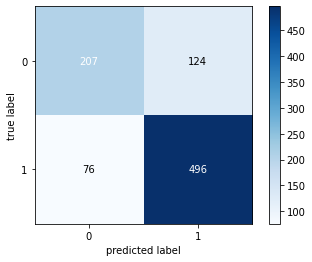

Original Data
                        precision    recall  f1-score   support

Negative for Pneumonia       0.35      0.72      0.47       331
    Typical Appearance       0.59      0.23      0.33       572

              accuracy                           0.41       903
             macro avg       0.47      0.47      0.40       903
          weighted avg       0.50      0.41      0.38       903



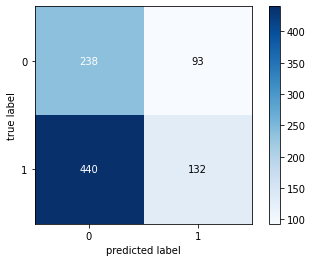

In [19]:
print("VMDed Data")
true_classes = Val_Data.classes
class_labels = list(Val_Data.class_indices.keys()) 
predicted_classes = (in1)
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
cm1 = confusion_matrix(true_classes,predicted_classes)
#print(cm2)
#Visualizing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm1, colorbar=True)
plt.show()

print("Original Data")
true_classes = Val_Data_OG.classes
class_labels = list(Val_Data_OG.class_indices.keys()) 
predicted_classes = (in2)
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)
cm1 = confusion_matrix(true_classes,predicted_classes)
#print(cm2)
#Visualizing confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm1, colorbar=True)
plt.show()
